# **Experiment 6**

Atharva Sonavane 2019120063 BE EXTC 

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error as MSE
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
color_palette = sns.color_palette()
plt.style.use('fivethirtyeight')

The Data taken for this experiment is Climate Data of Delhi City from the previous years and we will be doing time series analysis on various climate related variables

In [3]:
df = pd.read_csv("DailyDelhiClimateTrain.csv") 
df.set_index("date", inplace=True)
df.index = pd.to_datetime(df.index)

In [4]:
df.head(3)

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.5,0.000000,1015.666667
2013-01-02,7.400000,92.0,2.980000,1017.800000
2013-01-03,7.166667,87.0,4.633333,1018.666667


Take a look at the various variables provided to us and note any trends/periodical behaviour.

Mean temperature

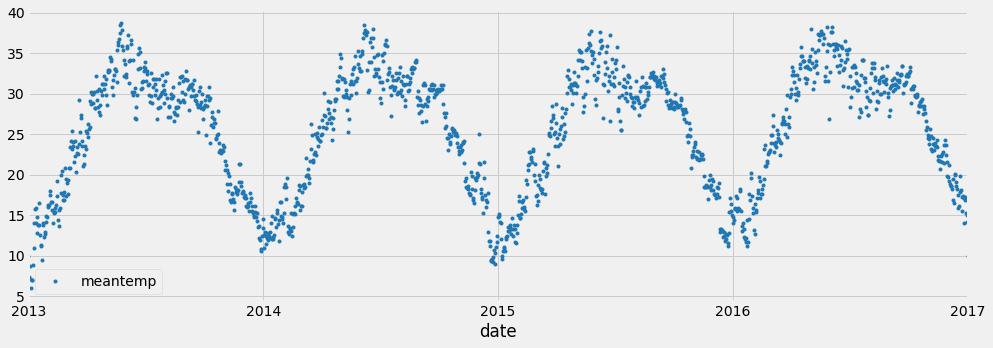

In [5]:
df.plot(y='meantemp', figsize=(15, 5), style='.', color=color_palette[0])

This feature seems to vary periodically. As seen in the graph, this feature increases until reaching its maximum point for that year at May. It then declines with a small spike around September/October.

Humidity

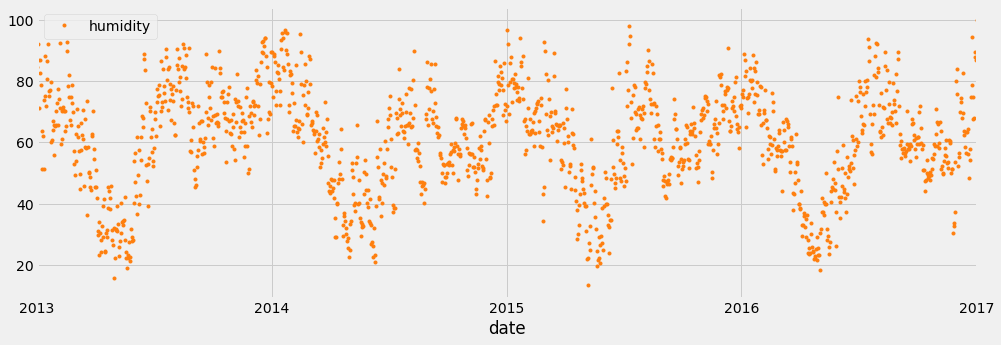

In [6]:
df.plot(y='humidity', figsize=(15, 5), style='.', color=color_palette[1])

This feature steeply dips around February/March and increases, albeit with some turbulence, during the fall/winter seasons.

Wind Speed

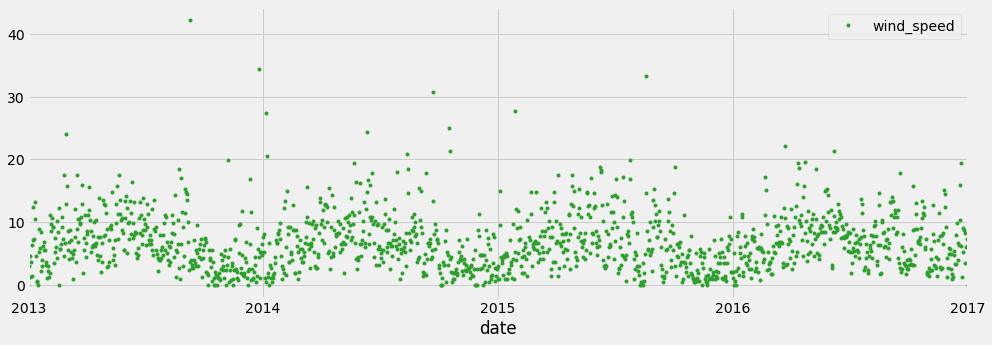

In [7]:
df.plot(y='wind_speed', figsize=(15, 5), style='.', color=color_palette[2])

The `wind_speed` in Dehli doesn't vary too much. As depicted in the graph, the wind speed increases during late spring/early summer and then proceeds to return to its original value as the year comes to a close.

Mean Pressure

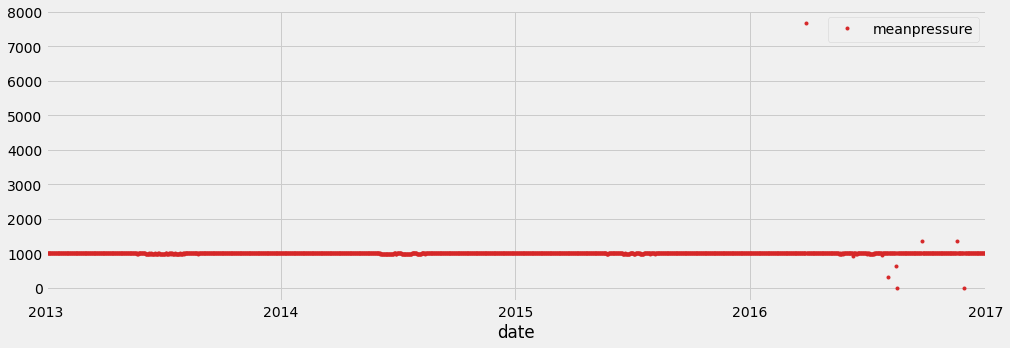

In [8]:
df.plot(y='meanpressure', figsize=(15, 5), style='.', color=color_palette[3])

Aside from the occasional outlier, the mean pressure barely varies at all.

Week-by-week exploration

In this subsection, We observe the distribution of the values of each feature. Moreover, this subsection is intended to confirm the trends observed in the previous section


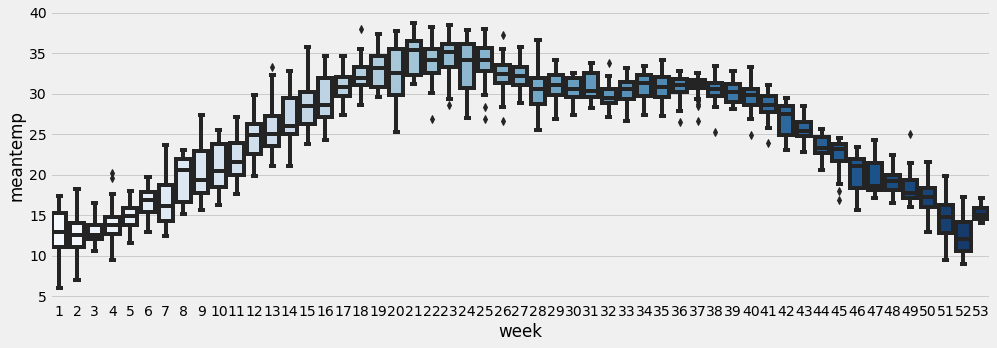

In [9]:
df['week'] = df.index.isocalendar().week
plt.figure(figsize=(15, 5))
sns.boxplot(data=df, x='week', y='meantemp', palette='Blues')

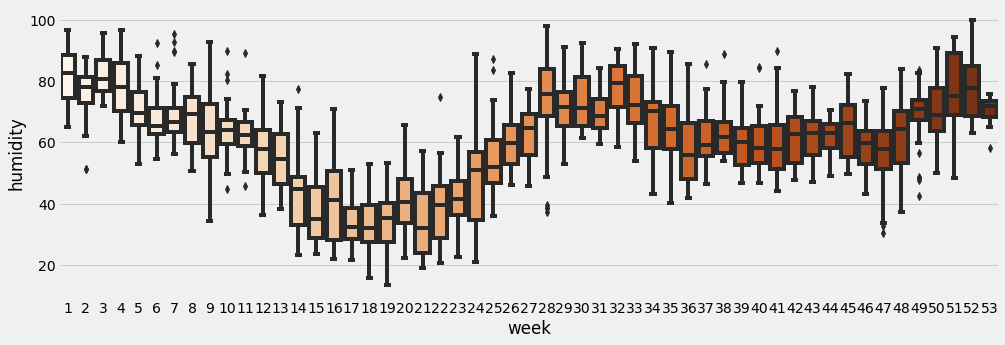

In [10]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=df, x='week', y='humidity', palette='Oranges')

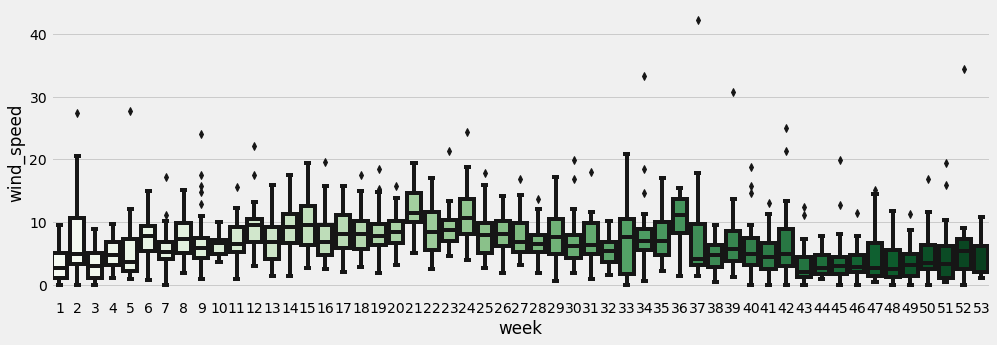

In [11]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=df, x='week', y='wind_speed', palette='Greens')

This definitely confirms the trends present in first section; however, I do have one concern. The graph of the distribution of wind speed has a low amount of variation. This low variation might make this particular feature hard to predict. Although, I do not think this low variation will substantially affect the performance of the model we will create.

Creating a model to predict the values of `meantemp`, `humidity`, and `wind_speed`.

We'll start by doing some feature engineering. To keep things simple, I'll add two new features, namely `week` and `month`.

In [12]:
def create_features(df):
    ret = df.copy()
    ret['week'] = ret.index.isocalendar().week
    ret['month'] = ret.index.month
    return ret

In [13]:
df = create_features(df)

## Train-Test Split

I'll use all dates before January 1, 2016 as my training set and all dates after January 1, 2016 as my test set.

In [14]:
train = df.loc[df.index < '2016-01-01']
test = df.loc[df.index >= '2016-01-01']

Before moving on, let's visualize the train/test split.

In [15]:
def plot_split(name):
    fig, ax = plt.subplots(figsize=(15, 5))
    train.plot(y=name, ax=ax, style='.', color=color_palette[0], title=f'{name} train/test split')
    test.plot(y=name, ax=ax, style='.', color=color_palette[2])
    ax.axvline('2016-01-01', color='black', ls='--')
    ax.legend(['Training Set', 'Test Set'])
    plt.show()

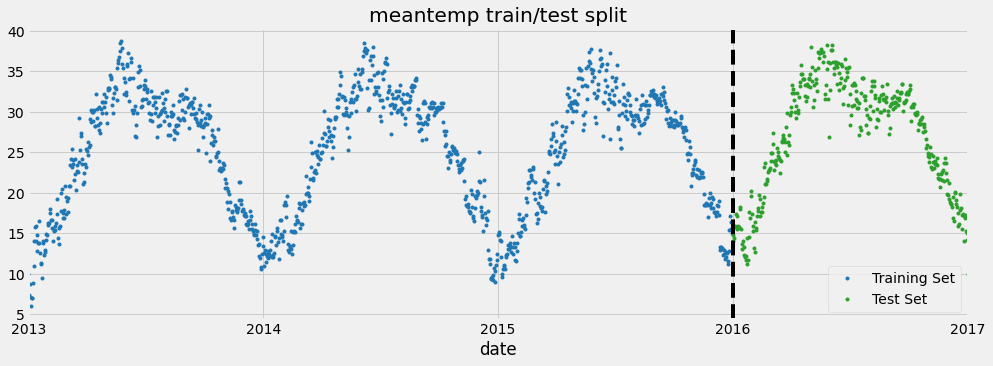

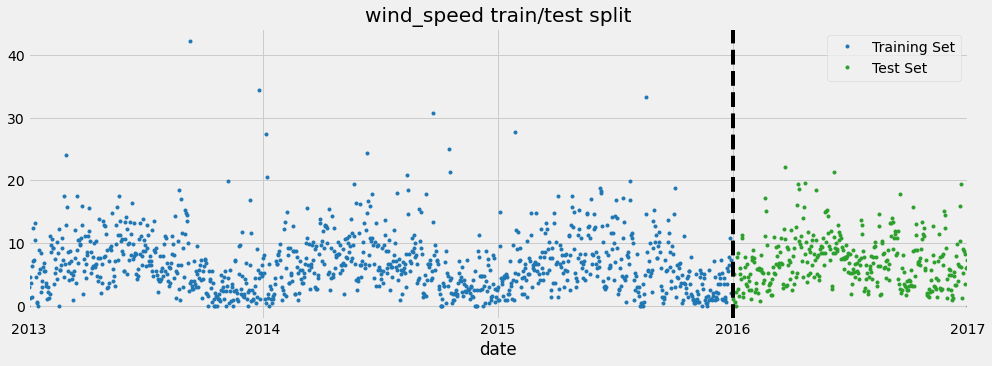

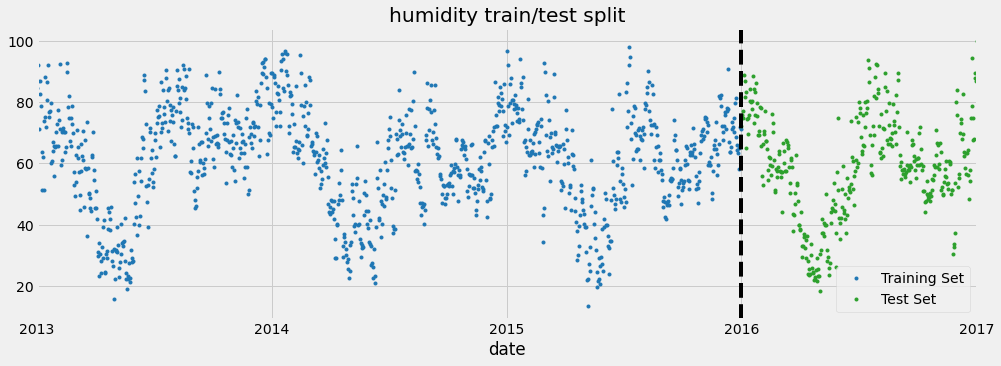

In [16]:
targets = ['meantemp', 'wind_speed', 'humidity']
for i in targets:
    plot_split(i)

## Utility Functions

This subsection involves the creation of certain utility functions.

The first function adjusts the changes the format of the DataFrame to something acceptable by XGBoost (the model we'll be using).

In [17]:
def rectify_format(features, target, train=train, test=test):
    X_train = train[features]
    y_train = train[target]
    
    X_test = test[features]
    y_test = test[target]
    
    X_train[features] = X_train[features].astype(np.int64)
    X_test[features] = X_test[features].astype(np.int64)
    
    return X_train, X_test, y_train, y_test

The second function simply plots the feature importances of the XGBoost Regressor.

In [18]:
def plot_feature_importance(reg):
    feature_importance = pd.DataFrame(reg.feature_importances_, index=reg.feature_names_in_, columns=['importance'])
    feature_importance.sort_values(by='importance').plot(kind='barh', title='Feature Importances')

This last function visualizes the predictions the model made on the test dataset.

In [19]:
def visualize_predictions(original, X_test, model, target):
    preds = X_test.copy()
    preds['Prediction'] = model.predict(X_test)
    
    fig, ax = plt.subplots(figsize=(15, 5))
    original.plot(ax=ax, y=target, color=color_palette[0], title='Predictions Visualized')
    preds.plot(ax=ax, y='Prediction', color=color_palette[2])
    ax.axvline('2016-01-01', color='black', ls='--')
    ax.legend(['actual', 'predicted'])

## Meantemp Training/Testing

### Setup

In [20]:
features = ['week', 'month']
target = 'meantemp'

In [21]:
X_train, X_test, y_train, y_test = rectify_format(features, target)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


### Training

In [22]:
mean_temp_reg = xgb.XGBRegressor(n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)
mean_temp_reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

[0]	validation_0-rmse:25.3169	validation_1-rmse:27.1944
[100]	validation_0-rmse:9.58052	validation_1-rmse:11.5129
[200]	validation_0-rmse:4.06541	validation_1-rmse:5.93867
[300]	validation_0-rmse:2.41263	validation_1-rmse:4.11609
[400]	validation_0-rmse:2.06098	validation_1-rmse:3.55946
[500]	validation_0-rmse:1.99524	validation_1-rmse:3.3965
[600]	validation_0-rmse:1.9794	validation_1-rmse:3.34394
[700]	validation_0-rmse:1.97268	validation_1-rmse:3.32881
[800]	validation_0-rmse:1.96913	validation_1-rmse:3.33117
[900]	validation_0-rmse:1.96678	validation_1-rmse:3.33623
[999]	validation_0-rmse:1.96499	validation_1-rmse:3.34194


XGBRegressor(early_stopping_rounds=50, learning_rate=0.01, n_estimators=1000,
             objective='reg:squarederror')

The root mean squared error is very low - a good sign.